In [1]:
import os
import numpy as np
import mne
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu, ranksums, wilcoxon
from statsmodels.stats.multitest import multipletests

# Higuchi’s Fractal Dimension function
from hfd import hfd  # Make sure you have installed/imported your HFD function

###############################################################################
#                     (A) User Parameters & Frequency Bands                   #
###############################################################################
# Define your frequency bands (you can modify or add more)
freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}

# Define scalp region indices (adjust if your channel naming differs)
# We'll fill these after we read at least one epochs file to get ch_names.
region_indices = {}

###############################################################################
#                         (B) Read File Names                                 #
###############################################################################
asmr_files = os.listdir("./asmr_epochs")
control_files = os.listdir("./control_epochs")

print("ASMR files found:", asmr_files)
print("Control files found:", control_files)

# Helper function to read all files in a folder, drop EOG channels, filter for a band,
# and extract "Open Eyes" and "Closed Eyes" data as numpy arrays.
def load_and_filter_epochs(folder_path, files_list, fmin, fmax):
    """
    Reads each file in files_list from folder_path, drops EOG channels,
    filters between (fmin, fmax), and returns:
      closed_data: (n_subjects, n_epochs, n_channels, n_times)
      open_data:   (n_subjects, n_epochs, n_channels, n_times)
    """
    closed_all = []
    open_all = []
    for filename in files_list:
        full_path = os.path.join(folder_path, filename)
        epochs = mne.read_epochs(full_path, verbose=False)
        # Drop EOG channels if present
        for eog_ch in ["HOEG", "VEOG"]:
            if eog_ch in epochs.ch_names:
                epochs.drop_channels([eog_ch], on_missing='ignore')
        # Filter
        epochs = epochs.filter(fmin, fmax, verbose=False)
        # Append data
        closed_all.append(epochs["Closed Eyes"].get_data())
        open_all.append(epochs["Open Eyes"].get_data())
    closed_all = np.array(closed_all)
    open_all = np.array(open_all)
    return closed_all, open_all, epochs.ch_names  # Return ch_names from the last file

###############################################################################
#            (C) Prepare to Collect All T-tests & P-values (for FDR)          #
###############################################################################
all_results = []   # Will store dicts with info about each test
all_pvals   = []   # Will store uncorrected p-values for FDR correction

###############################################################################
#                (D) Loop Over Each Frequency Band & Analyze                  #
###############################################################################
for band_name, (fmin, fmax) in freq_bands.items():
    print(f"\n===== Analyzing band: {band_name} ({fmin}–{fmax} Hz) =====")

    # 1) Load and filter data for this band
    asmr_closed_all, asmr_open_all, ch_names = load_and_filter_epochs(
        "./asmr_epochs", asmr_files, fmin, fmax
    )
    control_closed_all, control_open_all, _   = load_and_filter_epochs(
        "./control_epochs", control_files, fmin, fmax
    )

    # If you want to limit to first N subjects, do so here:
    N = 50
    asmr_closed_all   = asmr_closed_all[:N]
    asmr_open_all     = asmr_open_all[:N]
    control_closed_all = control_closed_all[:N]
    control_open_all   = control_open_all[:N]

    # Print shapes for sanity check
    print(f"  ASMR closed shape:   {asmr_closed_all.shape}")
    print(f"  ASMR open shape:     {asmr_open_all.shape}")
    print(f"  Control closed shape:{control_closed_all.shape}")
    print(f"  Control open shape:  {control_open_all.shape}")

    # 2) If region_indices is empty (first band we load), fill it now
    if not region_indices:
        occipital_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("O")]
        parietal_channels_indices  = [i for i, ch in enumerate(ch_names) if ch.startswith("P")]
        temporal_channels_indices  = [i for i, ch in enumerate(ch_names) if ch.startswith("T")]
        frontal_channels_indices   = [i for i, ch in enumerate(ch_names) if ch.startswith("F")]
        central_channels_indices   = [i for i, ch in enumerate(ch_names) if ch.startswith("C")]

        region_indices = {
            "Occipital": occipital_channels_indices,
            "Parietal":  parietal_channels_indices,
            "Temporal":  temporal_channels_indices,
            "Frontal":   frontal_channels_indices,
            "Central":   central_channels_indices
        }

    # 3) Loop over each region
    for region_name, region_chs in region_indices.items():
        print(f"  -> Region: {region_name} (channels: {region_chs})")

        # Extract region channels from each array
        # shape is (n_subjects, n_epochs, n_channels, n_times)
        asmr_cl_reg   = asmr_closed_all[:, :, region_chs, :]
        asmr_op_reg   = asmr_open_all[:,   :, region_chs, :]
        ctrl_cl_reg   = control_closed_all[:, :, region_chs, :]
        ctrl_op_reg   = control_open_all[:,   :, region_chs, :]

        # Flatten subject + epoch => (n_subj*n_epochs, n_ch, n_times)
        asmr_cl_reg = asmr_cl_reg.reshape(-1, asmr_cl_reg.shape[2], asmr_cl_reg.shape[3])
        asmr_op_reg = asmr_op_reg.reshape(-1, asmr_op_reg.shape[2], asmr_op_reg.shape[3])
        ctrl_cl_reg = ctrl_cl_reg.reshape(-1, ctrl_cl_reg.shape[2], ctrl_cl_reg.shape[3])
        ctrl_op_reg = ctrl_op_reg.reshape(-1, ctrl_op_reg.shape[2], ctrl_op_reg.shape[3])
        
        print(f"    ASMR closed region shape:   {asmr_cl_reg.shape}")
        print(f"    ASMR open region shape:     {asmr_op_reg.shape}")  
        print(f"    Control closed region shape:{ctrl_cl_reg.shape}")
        print(f"    Control open region shape:  {ctrl_op_reg.shape}")
        # 4) Compute HFD across channels, average per trial
        def compute_avg_hfd(data_3d):
            """
            data_3d: shape (n_trials, n_channels, n_times)
            Returns 1D array of length n_trials with mean(HFD) across channels
            """
            hfd_values = []
            for trial_ix in range(data_3d.shape[0]):
                vals = []
                for ch_ix in range(data_3d.shape[1]):
                    vals.append(hfd(data_3d[trial_ix, ch_ix, :], kmax=None))
                hfd_values.append(np.mean(vals))  # average across channels
            return np.array(hfd_values)

        asmr_cl_hfd = compute_avg_hfd(asmr_cl_reg)
        asmr_op_hfd = compute_avg_hfd(asmr_op_reg)
        ctrl_cl_hfd = compute_avg_hfd(ctrl_cl_reg)
        ctrl_op_hfd = compute_avg_hfd(ctrl_op_reg)

        # 5) Perform two t-tests: Closed and Open
        #    a) Closed
        # a) Closed
        # t_stat_cl, p_val_cl = ttest_ind(asmr_cl_hfd, ctrl_cl_hfd, equal_var=True)
        # t_stat_cl, p_val_cl = mannwhitneyu(asmr_cl_hfd, ctrl_cl_hfd) 
        t_stat_cl, p_val_cl = ranksums(asmr_cl_hfd, ctrl_cl_hfd)
        # t_stat_cl, p_val_cl = wilcoxon(asmr_cl_hfd, ctrl_cl_hfd)  # Paired t-test

        n1 = len(asmr_cl_hfd)
        n2 = len(ctrl_cl_hfd)
        df_closed = n1 + n2 - 2
        print(df_closed)
        all_results.append({
            "Band": band_name,
            "Region": region_name,
            "Condition": "Closed",
            "t_stat": t_stat_cl,
            "df": df_closed,
            "p_uncorrected": p_val_cl,
            "ASMR_values": asmr_cl_hfd,
            "Control_values": ctrl_cl_hfd
        })
        all_pvals.append(p_val_cl)


        #    b) Open
        # b) Open
        # t_stat_op, p_val_op = ttest_ind(asmr_op_hfd, ctrl_op_hfd, equal_var=True)
        # t_stat_op, p_val_op = mannwhitneyu(asmr_op_hfd, ctrl_op_hfd)
        t_stat_op, p_val_op = ranksums(asmr_op_hfd, ctrl_op_hfd) 
        # t_stat_op, p_val_op = wilcoxon(asmr_op_hfd, ctrl_op_hfd)  # Paired t-test

        n1 = len(asmr_op_hfd)
        n2 = len(ctrl_op_hfd)
        df_open = n1 + n2 - 2
        all_results.append({
            "Band": band_name,
            "Region": region_name,
            "Condition": "Open",
            "t_stat": t_stat_op,
            "df": df_open,
            "p_uncorrected": p_val_op,
            "ASMR_values": asmr_op_hfd,
            "Control_values": ctrl_op_hfd
        })
        all_pvals.append(p_val_op)


###############################################################################
#       (E) FDR-correct all p-values across all bands × regions × conditions  #
###############################################################################
print(f"\nTotal number of t-tests: {len(all_pvals)}")
reject_flags, pvals_corrected, _, _ = multipletests(all_pvals, method='fdr_bh')

# Insert corrected p-values & significance into all_results
for i, (res_dict, p_corr, reject) in enumerate(zip(all_results, pvals_corrected, reject_flags)):
    res_dict["p_corrected"] = p_corr
    res_dict["Significant"] = reject

###############################################################################
#        (F) Boxplot function to visualize significant comparisons            #
###############################################################################
def plot_boxplot(asmr_values, ctrl_values, title, p_corr, filename):
    """
    Plots a boxplot comparing two groups (ASMR vs. Control) with a significance line.
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Create the boxplot
    bp = ax.boxplot([asmr_values, ctrl_values],
                    positions=[1, 2],
                    patch_artist=True,
                    showmeans=True,
                    widths=0.7)

    # Optional color fill
    colors = ['orange', 'green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Jittered data points
    for i, d in enumerate([asmr_values, ctrl_values]):
        x_jitter = np.random.normal(1 + i, 0.04, size=len(d))
        ax.scatter(x_jitter, d, color="black", alpha=0.7)

    ax.set_xticks([1, 2])
    ax.set_xticklabels(["ASMR", "Control"], fontsize=14, color="black")
    ax.set_ylabel("HFD", fontsize=14, color="black")
    ax.set_title(title, fontsize=16, color="black")
    ax.grid(True)

    # Significance annotation
    max_val = max(np.max(asmr_values), np.max(ctrl_values))
    y_base = max_val + 0.05 * max_val
    y_top = y_base + 0.05 * max_val

    # Decide on star annotation
    if p_corr < 0.001:
        sig_text = '***'
    elif p_corr < 0.05:
        sig_text = '**'
    elif p_corr < 0.1:
        sig_text = '*'
    else:
        sig_text = ''

    if sig_text != '':
        ax.plot([1, 1, 2, 2], [y_base, y_top, y_top, y_base], lw=1.5, color='black')
        ax.text(1.5, y_top, sig_text, ha='center', va='bottom', fontsize=16, color='black')

    plt.tight_layout()
    os.makedirs("plots", exist_ok=True)
    plt.savefig(filename, dpi=300)
    plt.close()

###############################################################################
# (G) Plot only the comparisons with p_corrected < 0.1, and store them in CSV
###############################################################################
significant_results = []
for res in all_results:
    if res["p_corrected"] < 0.1:
        # Construct a safe filename
        cond_str = "Closed" if res["Condition"] == "Closed" else "Open"
        band_str = res["Band"].replace(" ", "_")
        region_str = res["Region"].replace(" ", "_")
        fname = f"plots/{cond_str}_Eyes_{band_str}_{region_str}_HFD.png"

        # Title for the plot
        title_str = (f"{res['Region']} | {res['Band']} band | {res['Condition']} Eyes\n"
                     f"p_corr = {res['p_corrected']:.3f}")

        plot_boxplot(res["ASMR_values"], res["Control_values"], title_str, res["p_corrected"], fname)

        # Also collect in a final list
        significant_results.append({
                
                "Band":       res["Band"],
                "Region":     res["Region"],
                "Condition":  res["Condition"],
                "t_stat":     res["t_stat"],
                "df":         res["df"],
                "p_uncorrected": res["p_uncorrected"],
                "p_corrected":   res["p_corrected"],
                "Significant":   True
            })


# Save significant results to CSV
df_sig = pd.DataFrame(significant_results)
df_sig.to_csv("plots/significant_pvalues.csv", index=False)
print("\nSignificant results saved to 'plots/significant_pvalues.csv'")
print("Done!")


ASMR files found: ['16-epochs-epo.fif', '8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']
Control files found: ['8-epochs-epo.fif', '10-epochs-epo.fif', '1-epochs-epo.fif', '11-epochs-epo.fif', '9-epochs-epo.fif', '14-epochs-epo.fif', '12-epochs-epo.fif', '13-epochs-epo.fif', '2-epochs-epo.fif', '6-epochs-epo.fif', '7-epochs-epo.fif', '15-epochs-epo.fif', '5-epochs-epo.fif', '3-epochs-epo.fif', '4-epochs-epo.fif']

===== Analyzing band: Delta (1–4 Hz) =====
  ASMR closed shape:   (16, 3, 31, 15001)
  ASMR open shape:     (16, 3, 31, 15001)
  Control closed shape:(15, 3, 31, 15001)
  Control open shape:  (15, 3, 31, 15001)
  -> Region: Occipital (channels: [14, 15, 16])
    ASMR closed region shape:   (48, 3, 15001)
    ASMR open regio

In [2]:
###############################################################################
# (G) Plot only the comparisons with p_corrected < 0.1, and store them in CSV
###############################################################################
significant_results = []
for res in all_results:
    if res["p_corrected"] < 0.1:
        # Construct a safe filename
        cond_str = "Closed" if res["Condition"] == "Closed" else "Open"
        band_str = res["Band"].replace(" ", "_")
        region_str = res["Region"].replace(" ", "_")
        fname = f"plots/{cond_str}_Eyes_{band_str}_{region_str}_HFD.png"

        # Title for the plot
        title_str = (f"{res['Region']} | {res['Band']} band | {res['Condition']} Eyes\n"
                     f"p_corr = {res['p_corrected']:.3f}")

        plot_boxplot(res["ASMR_values"], res["Control_values"], title_str, res["p_corrected"], fname)

        # Also collect in a final list
        significant_results.append({
                
                "Band":       res["Band"],
                "Region":     res["Region"],
                "Condition":  res["Condition"],
                "t_stat":     res["t_stat"],
                "df":         res["df"],
                "p_uncorrected": res["p_uncorrected"],
                "p_corrected":   res["p_corrected"],
                "Significant":   True
            })


# Save significant results to CSV
df_sig = pd.DataFrame(significant_results)
df_sig.to_csv("plots/significant_pvalues.csv", index=False)
print("\nSignificant results saved to 'plots/significant_pvalues.csv'")
print("Done!")


Significant results saved to 'plots/significant_pvalues.csv'
Done!


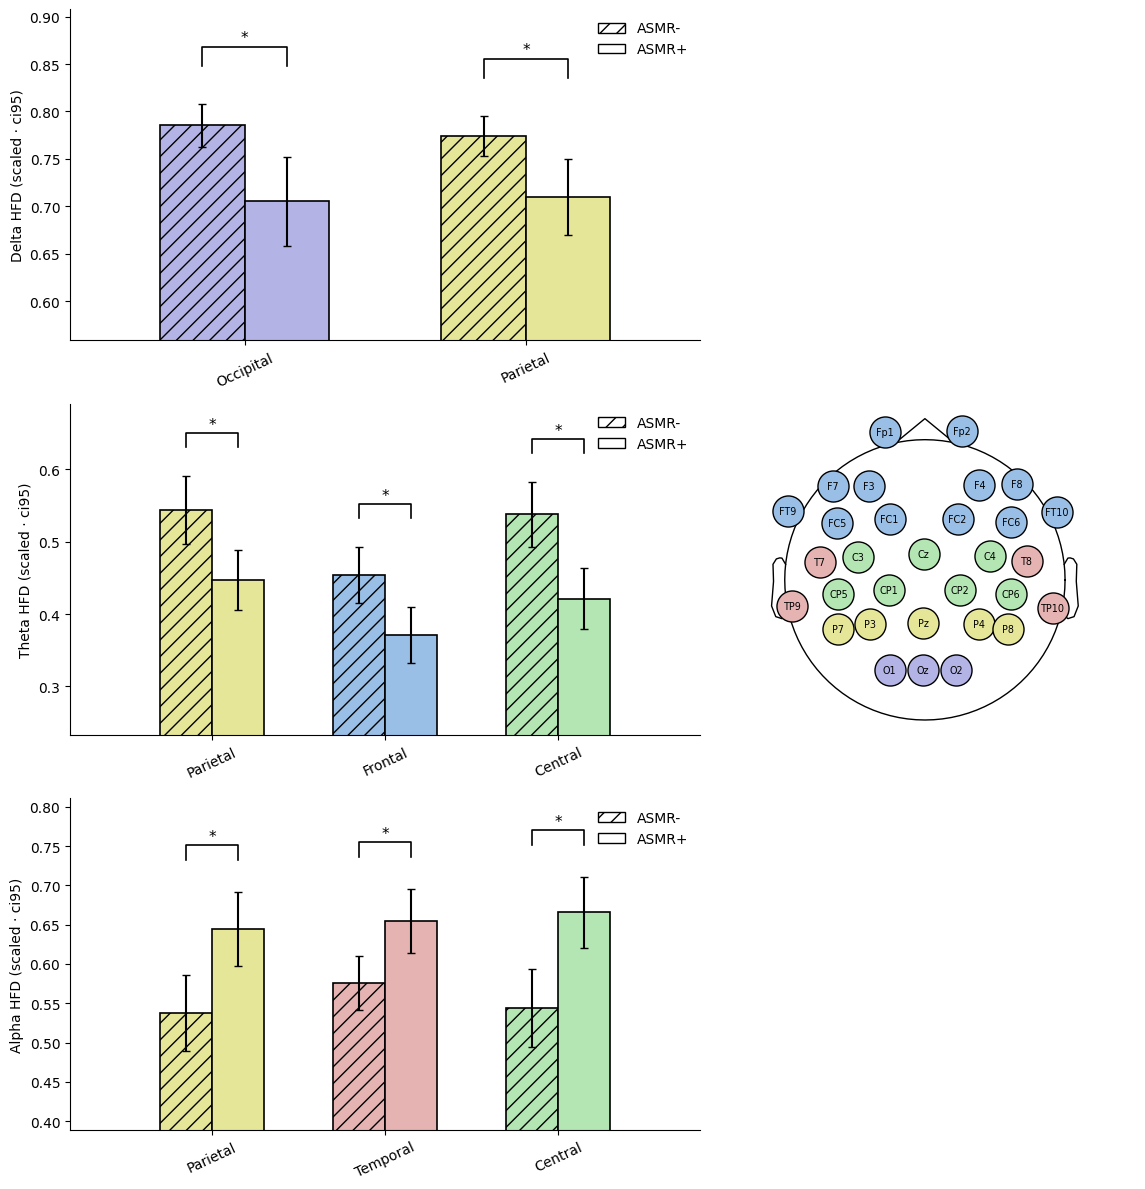

In [3]:
import numpy as np, matplotlib.pyplot as plt, mne
from matplotlib.patches import Patch

# ───────── parameters ─────────
P_THRESH  = 0.05
ERR_KIND  = "ci95"          # "std" | "sem" | "ci95"
REGION_COLORS = {          # pastel palette
    "Frontal":   (0.60, 0.75, 0.90),
    "Central":   (0.70, 0.90, 0.70),
    "Temporal":  (0.90, 0.70, 0.70),
    "Parietal":  (0.90, 0.90, 0.60),
    "Occipital": (0.70, 0.70, 0.90),
    "Other":     (0.85, 0.85, 0.85, 0.15)
}

# ───────── helpers ─────────
def p_to_star(p):
    return "***" if p<.001 else "**" if p<.01 else "*" if p<.05 else ""

def err_bar(values):                       # values = list[np.array]
    if ERR_KIND == "std":
        return np.array([v.std(ddof=1) for v in values])
    if ERR_KIND == "sem":
        return np.array([v.std(ddof=1)/np.sqrt(len(v)) for v in values])
    if ERR_KIND == "ci95":
        return np.array([1.96*v.std(ddof=1)/np.sqrt(len(v)) for v in values])
    raise ValueError("ERR_KIND must be 'std', 'sem', or 'ci95'")

def draw_topomap_on_axis(epo, ax, s_size=4000):
    chs = epo.ch_names
    regs = {n:[i for i,ch in enumerate(chs) if ch.startswith(pref)]
            for n,pref in zip(["Frontal","Central","Temporal","Parietal","Occipital"],
                              ["F","C","T","P","O"])}
    regs["Other"] = np.setdiff1d(np.arange(len(chs)),
                                 np.concatenate(list(regs.values())))
    mne.viz.plot_sensors(epo.info, kind="topomap", ch_type="eeg",
                         axes=ax, show_names=False, show=False,
                         ch_groups=list(regs.values()))
    pos = ax.collections[0].get_offsets(); ax.collections[0].set_visible(False)
    for reg,idx in regs.items():
        if len(idx):
            ax.scatter(pos[idx,0], pos[idx,1], s=s_size, marker="o",
                       c=[REGION_COLORS[reg]], edgecolors="k",
                       linewidths=1.0, zorder=3 if reg!="Other" else 2)
    for i,name in enumerate(chs):
        ax.text(pos[i,0], pos[i,1], name, ha="center", va="center",
                fontsize="x-small", color="black", zorder=4)
    for sp in ax.spines.values(): sp.set_linewidth(1.3)

# ───────── data filter/load ─────────
sig_open = [r for r in all_results
            if r["Condition"]=="Open" and r["p_corrected"]<P_THRESH]
by_band={}
for r in sig_open: by_band.setdefault(r["Band"],[]).append(r)

epochs = mne.read_epochs(
    "/home/s.dharia-ra/Shyamal/ASMR_NEW/statstical_analysis/asmr_epochs/1-epochs-epo.fif",
    verbose=False, preload=False
)

# ───────── plotting ─────────
bands=list(by_band.keys()); n_bands=len(bands); mid=n_bands//2
fig,axes = plt.subplots(n_bands,2,figsize=(12,4*n_bands),
                        gridspec_kw=dict(width_ratios=[3,2]))
if n_bands==1: axes=axes[np.newaxis,:]

for i,band in enumerate(bands):
    res  = by_band[band]
    regs = [r["Region"] for r in res]
    vals_as=[np.asarray(r["ASMR_values"])    for r in res]
    vals_ct=[np.asarray(r["Control_values"]) for r in res]
    mean_as=np.array([v.mean() for v in vals_as])
    mean_ct=np.array([v.mean() for v in vals_ct])
    err_as,err_ct = err_bar(vals_as), err_bar(vals_ct)

    # 0-1 scaling per band
    vmin,vmax = np.hstack(vals_as+vals_ct).min(), np.hstack(vals_as+vals_ct).max()
    scale = vmax-vmin
    mean_as = (mean_as-vmin)/scale; mean_ct=(mean_ct-vmin)/scale
    err_as  = err_as/scale;        err_ct = err_ct/scale

    ax = axes[i,0]; x=np.arange(len(regs))*0.6; w=0.18
    cols=[REGION_COLORS[r] for r in regs]
    
    # Changed order: Control (ASMR-) first, then ASMR (ASMR+)
    ax.bar(x-w/2, mean_ct, w, yerr=err_ct, capsize=3,
           color=cols, edgecolor='k', lw=1.2, hatch='//')
    ax.bar(x+w/2, mean_as, w, yerr=err_as, capsize=3,
           color=cols, edgecolor='k', lw=1.2)
    
    ax.set_xticks(x); ax.set_xticklabels(regs, rotation=25)
    ax.set_ylabel(f"{band} HFD (scaled · {ERR_KIND})")
    ymin, ymax = (min(np.hstack([mean_as-err_as, mean_ct-err_ct])),
                  max(np.hstack([mean_as+err_as, mean_ct+err_ct])))
    # ax.set_ylim(ymin, ymax)
    ax.set_ylim(ymin - 0.1, ymax + 0.1)

    # ax.set_ylim(0,1)                           # fixed 0-1 axis

    for j,p in enumerate([r["p_corrected"] for r in res]):
        star=p_to_star(p)
        if star:
            top=max(mean_as[j]+err_as[j], mean_ct[j]+err_ct[j])
            y=min(0.96, top+0.04)              # keep inside
            ax.plot([x[j]-w/2,x[j]-w/2,x[j]+w/2,x[j]+w/2],
                    [y,y+0.02,y+0.02,y],'k-',lw=1.2)
            ax.text(x[j], y+0.025, star, ha="center", fontsize=11)
    ax.spines[['top','right']].set_visible(False)
    ax.margins(x=0.2)
    
    # Updated legend order to match bar order
    ax.legend(handles=[
        Patch(facecolor='white', edgecolor='k', hatch='//', label='ASMR-'), # Control
        Patch(facecolor='white', edgecolor='k', label='ASMR+')  # ASMR
    ], frameon=False, loc='upper right')

    topo_ax=axes[i,1]
    topo_ax.axis("off")
    if i==mid: draw_topomap_on_axis(epochs, topo_ax, s_size=500)

plt.tight_layout(); fig.subplots_adjust(left=0.10)
fig.savefig("plots/all_bands_with_single_topomap.png", dpi=300)
plt.show()

In [4]:
"""
hfd_stats_per_channel.py
────────────────────────
• Computes Higuchi’s fractal dimension (HFD) for every single channel
  in ASMR vs. control data.
• Two‐sample Welch t-tests (Closed-Eyes and Open-Eyes separately)
  are run per channel × band.
• Benjamini-Hochberg FDR correction is applied across **all**
  band × channel × condition comparisons.
• Significant tests (q < 0.10) are visualised as box-plots and saved
  to ./plots, and their statistics are written to CSV.
"""
import os, numpy as np, mne, pandas as pd, matplotlib.pyplot as plt
from scipy.stats               import ttest_ind, ranksums
from statsmodels.stats.multitest import multipletests
from hfd import hfd                    # your HFD implementation

# ───────────────────────────── parameters ────────────────────────────
freq_bands = {                       # modify if you wish
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}
N_SUBJECTS = None                    # set --> e.g. 10 to subsample

asmr_dir     = "./asmr_epochs"
control_dir  = "./control_epochs"
plot_dir     = "./plots"
os.makedirs(plot_dir, exist_ok=True)

# ───────────────────── helper: load & band-pass one folder ───────────
def load_filter(folder, files, fmin, fmax):
    closed, open_, ch_names = [], [], []
    for fn in files:
        ep = mne.read_epochs(os.path.join(folder, fn), verbose=False)
        ep.drop_channels([ch for ch in ("HOEG", "VEOG") if ch in ep.ch_names],
                         on_missing="ignore")
        ep = ep.filter(fmin, fmax, verbose=False)
        closed.append(ep["Closed Eyes"].get_data())
        open_.append(ep["Open Eyes"].get_data())
        ch_names = ep.ch_names                       # keep for later
    return (np.array(closed), np.array(open_), ch_names)

# ─────────────────────── helper: HFD per trial × channel ────────────
def hfd_trials(data4d):
    """
    data4d shape: (n_subj, n_ep, n_ch, n_t)
    returns: ndarray (n_subj*n_ep, n_ch)
    """
    flat = data4d.reshape(-1, data4d.shape[2], data4d.shape[3])
    out  = np.zeros((flat.shape[0], flat.shape[1]))
    for tr in range(flat.shape[0]):
        for ch in range(flat.shape[1]):
            out[tr, ch] = hfd(flat[tr, ch], kmax=None)
    return out

# ───────────────────────────── main loop ─────────────────────────────
asmr_files    = sorted(os.listdir(asmr_dir))
control_files = sorted(os.listdir(control_dir))

all_tests, all_p = [], []

for band, (fmin, fmax) in freq_bands.items():
    print(f"\n=== {band}  {fmin}-{fmax} Hz ===")

    as_cl, as_op, ch_names = load_filter(asmr_dir,    asmr_files,    fmin, fmax)
    co_cl, co_op, _        = load_filter(control_dir, control_files, fmin, fmax)

    if N_SUBJECTS:
        as_cl, as_op = as_cl[:N_SUBJECTS], as_op[:N_SUBJECTS]
        co_cl, co_op = co_cl[:N_SUBJECTS], co_op[:N_SUBJECTS]

    # HFD (n_trials, n_ch)
    as_cl_hfd = hfd_trials(as_cl)
    as_op_hfd = hfd_trials(as_op)
    co_cl_hfd = hfd_trials(co_cl)
    co_op_hfd = hfd_trials(co_op)

    # iterate over channels
    for ch_idx, ch in enumerate(ch_names):
        # Closed
        # t_cl, p_cl = ttest_ind(as_cl_hfd[:, ch_idx], co_cl_hfd[:, ch_idx],
        #                        equal_var=False)      # Welch is safer
        t_cl, p_cl = ranksums(as_cl_hfd[:, ch_idx], co_cl_hfd[:, ch_idx])
        df_cl = (len(as_cl_hfd[:, ch_idx]) + len(co_cl_hfd[:, ch_idx]) - 2)

        all_tests.append(dict(Band=band, Channel=ch, Condition="Closed",
                              t_stat=t_cl, df=df_cl,
                              p_uncorrected=p_cl,
                              ASMR=as_cl_hfd[:, ch_idx],
                              Control=co_cl_hfd[:, ch_idx]))
        all_p.append(p_cl)

        # Open
        # t_op, p_op = ttest_ind(as_op_hfd[:, ch_idx], co_op_hfd[:, ch_idx],
        #                        equal_var=False)
        t_op, p_op = ranksums(as_op_hfd[:, ch_idx], co_op_hfd[:, ch_idx])
        df_op = (len(as_op_hfd[:, ch_idx]) + len(co_op_hfd[:, ch_idx]) - 2)

        all_tests.append(dict(Band=band, Channel=ch, Condition="Open",
                              t_stat=t_op, df=df_op,
                              p_uncorrected=p_op,
                              ASMR=as_op_hfd[:, ch_idx],
                              Control=co_op_hfd[:, ch_idx]))
        all_p.append(p_op)

# ─────────────────────── FDR correction & annotation ─────────────────
rejected, p_corr, *_ = multipletests(all_p, method="fdr_bh")

for rec, q in zip(all_tests, p_corr):
    rec["p_corrected"] = q
    rec["Significant"] = bool(rec in [t for i,t in enumerate(all_tests) if rejected[i]])

# ───────────────────── helper: pretty box-plot ───────────────────────
def boxplot(asmr, ctrl, title, q, out_png):
    fig, ax = plt.subplots(figsize=(4.5, 5))
    bp = ax.boxplot([asmr, ctrl], positions=[1, 2], patch_artist=True,
                    showmeans=True, widths=.6)
    for patch, col in zip(bp["boxes"], ["#FFB347", "#9ACD32"]):
        patch.set_facecolor(col)
    for i, d in enumerate([asmr, ctrl]):
        ax.scatter(np.random.normal(1+i, .04, len(d)), d, color="k", alpha=.6, s=15)

    ax.set_xticks([1,2]); ax.set_xticklabels(["ASMR","Control"])
    ax.set_ylabel("HFD"); ax.set_title(title); ax.grid(True, ls=":")
    # significance bar
    if q < .10:
        y = max(max(asmr), max(ctrl))*1.05
        ax.plot([1,1,2,2], [y,y*1.03,y*1.03,y], lw=1.2, c="k")
        stars = "***" if q<.001 else ("**" if q<.05 else "*")
        ax.text(1.5, y*1.03, stars, ha="center", va="bottom", fontsize=14)
    fig.tight_layout(); fig.savefig(out_png, dpi=300); plt.close(fig)

# ───────────────────────── plotting & CSV ────────────────────────────
sig_rows = []
for rec in all_tests:
    if rec["p_corrected"] < .10:
        fname = f"{plot_dir}/{rec['Condition']}_{rec['Band']}_{rec['Channel']}.png"
        ttl   = (f"{rec['Channel']}  |  {rec['Band']}  |  "
                 f"{rec['Condition']} Eyes\nq = {rec['p_corrected']:.3f}")
        boxplot(rec["ASMR"], rec["Control"], ttl, rec["p_corrected"], fname)
        sig_rows.append(rec)

pd.DataFrame(sig_rows).to_csv(f"{plot_dir}/significant_pvalues.csv", index=False)
print(f"\n✓ Finished. {len(sig_rows)} tests survived FDR (q<0.10). "
      f"Plots & CSV saved to '{plot_dir}'")


=== Delta  1-4 Hz ===

=== Theta  4-8 Hz ===

=== Alpha  8-12 Hz ===

=== Beta  12-30 Hz ===

=== Gamma  30-45 Hz ===

✓ Finished. 55 tests survived FDR (q<0.10). Plots & CSV saved to './plots'


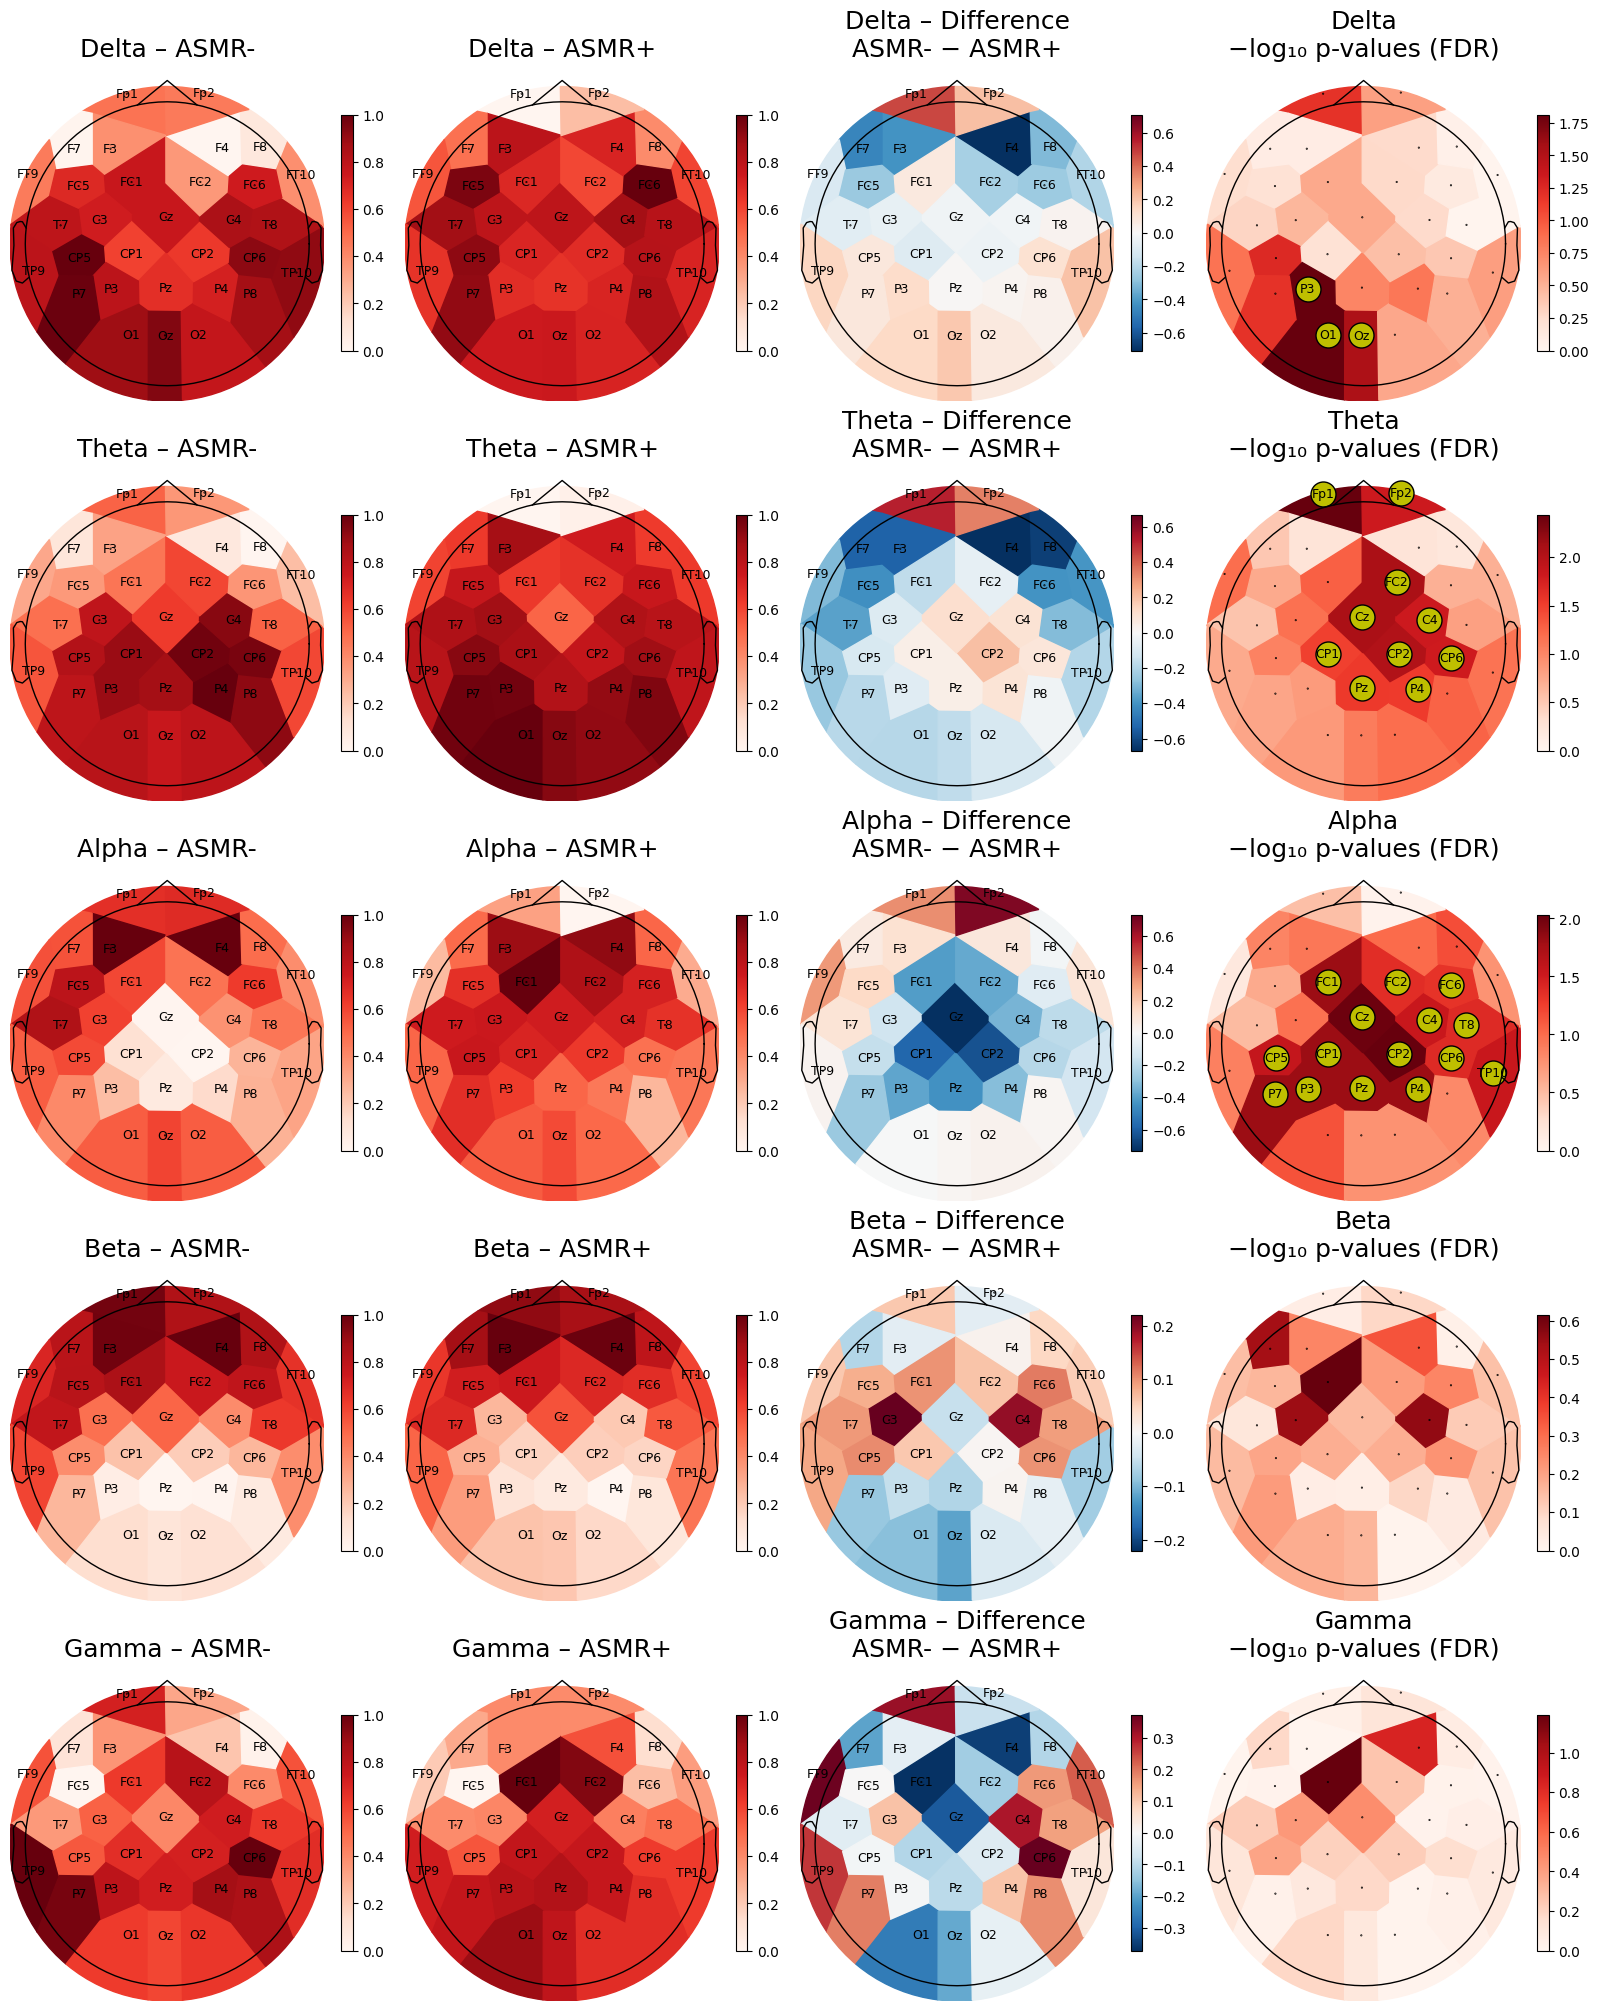

In [5]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

# ───────────────────────────────────────────────────────────────
#  Assumes `all_tests` exists with p_corrected (FDR-adjusted) and
#  you have one epochs file to supply montage / info.
# ───────────────────────────────────────────────────────────────

open_tests = pd.DataFrame([rec for rec in all_tests if rec["Condition"] == "Open"])

# load an epochs file only for channel locations
epochs = mne.read_epochs(
    "asmr_epochs/1-epochs-epo.fif",
    verbose=False,
)

# use only the EEG sensors present in both the montage and the stats
picks_eeg = mne.pick_types(epochs.info, meg=False, eeg=True)
montage_order = [epochs.ch_names[i] for i in picks_eeg]

bands = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]

fig, axes = plt.subplots(5, 4, figsize=(16, 20), constrained_layout=True)

for row, band in enumerate(bands):
    df_band = open_tests.query("Band == @band")

    # build DataFrame indexed by Channel, then align to montage order
    per_chan = (
        df_band.assign(
            mean_ASMR=lambda df: df["ASMR"].apply(np.mean),
            mean_Control=lambda df: df["Control"].apply(np.mean),
        )
        .set_index("Channel")
        .reindex(montage_order)         # ← alignment fix
        .dropna(subset=["mean_ASMR"])   # drop chans not present in stats
        .reset_index()
    )

    ch_names      = per_chan["Channel"].tolist()
    asmr_means    = per_chan["mean_ASMR"].to_numpy()
    control_means = per_chan["mean_Control"].to_numpy()
    pvals_corr    = per_chan["p_corrected"].to_numpy()
    sig_mask      = pvals_corr < 0.05

    # min–max normalisation per map
    asmr_norm    = (asmr_means - asmr_means.min()) / (asmr_means.max() - asmr_means.min())
    control_norm = (control_means - control_means.min()) / (control_means.max() - control_means.min())
    diff_norm    = control_norm - asmr_norm         # change sign if needed

    ax0, ax1, ax2, ax3 = axes[row]

    # Changed order and labels: ASMR- first, then ASMR+
    im0, _ = plot_topomap(control_norm, epochs.info, axes=ax0, show=False,
                          contours=0, names=ch_names, image_interp="nearest")
    ax0.set_title(f"{band} – ASMR-", fontsize=18)  # Control → ASMR-
    fig.colorbar(im0, ax=ax0, orientation="vertical", shrink=0.7)

    im1, _ = plot_topomap(asmr_norm, epochs.info, axes=ax1, show=False,
                          contours=0, names=ch_names, image_interp="nearest")
    ax1.set_title(f"{band} – ASMR+", fontsize=18)  # ASMR → ASMR+
    fig.colorbar(im1, ax=ax1, orientation="vertical", shrink=0.7)

    im2, _ = plot_topomap(diff_norm, epochs.info, axes=ax2, show=False,
                          contours=0, names=ch_names, cmap="RdBu_r", image_interp="nearest")
    ax2.set_title(f"{band} – Difference\nASMR- − ASMR+", fontsize=18)  # Updated difference label
    fig.colorbar(im2, ax=ax2, orientation="vertical", shrink=0.7)

    im3, _ = plot_topomap(-np.log10(pvals_corr), epochs.info, axes=ax3, show=False,
                          contours=0, names=ch_names, cmap="Reds",
                          mask=sig_mask, mask_params=dict(markersize=18,
                                                          markerfacecolor="y",
                                                          markeredgecolor="k",
                                                          linewidth=0),
                          image_interp="nearest")
    ax3.set_title(f"{band}\n−log₁₀ p-values (FDR)", fontsize=18)
    fig.colorbar(im3, ax=ax3, orientation="vertical", shrink=0.7)

# uniform label font size
for ax in axes.flat:
    for txt in ax.texts:
        txt.set_fontsize(9)

plt.show()
fig.savefig("all_bands_topomaps_nearest.png", dpi=300)

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.stats import ttest_ind
# from statsmodels.stats.multitest import multipletests

# # Use a nice ggplot style
# plt.style.use('ggplot')

# # Create the plots directory if it doesn't exist
# os.makedirs("plots", exist_ok=True)

# # Example frequency vector (assuming asmr_closed.shape[2] is the number of frequency bins)
# fs = 250
# n_freqs = asmr_closed.shape[2]
# freqs = np.linspace(0, fs, n_freqs)

# # Define frequency bands
# freq_bands = {
#     "Delta": (1, 4),
#     "Theta": (4, 8),
#     "Alpha": (8, 12),
#     "Beta":  (12, 30),
#     "Gamma": (30, 45)
# }

# # Assume that epochs is defined and contains the original channel names.
# ch_names = epochs.ch_names

# occipital_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("O")]
# parietal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("P")]
# temporal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("T")]
# frontal_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("F")]
# central_channels_indices = [i for i, ch in enumerate(ch_names) if ch.startswith("C")]

# # Regions and channel indices
# regions = ["Occipital", "Parietal", "Temporal", "Frontal", "Central"]
# channel_indices = [
#     occipital_channels_indices,
#     parietal_channels_indices,
#     temporal_channels_indices,
#     frontal_channels_indices,
#     central_channels_indices
# ]

# # Dictionaries to store keys, p-values, and data (including t-statistics and degrees of freedom)
# closed_keys = []
# closed_pvals = []
# closed_data = {}  # key: (region, band, "closed") -> dict with keys: 'asmr', 'control', 't_stat', 'df'
# open_keys = []
# open_pvals = []
# open_data = {}    # key: (region, band, "open") -> dict with keys: 'asmr', 'control', 't_stat', 'df'

# # For saving significant results in a CSV.
# significant_results = []

# # Loop over regions and frequency bands to compute tests and store data.
# for r_idx, region in enumerate(regions):
#     indices = channel_indices[r_idx]
#     # Filter indices to only include values valid for asmr_closed (and similar arrays)
#     valid_indices = [i for i in indices if i < asmr_closed.shape[1]]
    
#     for band_name, (low_freq, high_freq) in freq_bands.items():
#         # Create a mask for frequencies within the band.
#         band_mask = (freqs >= low_freq) & (freqs <= high_freq)
        
#         ### CLOSED EYES CONDITION ###
#         # Extract and reduce PSD for the region and frequency band:
#         # First, use only the valid indices.
#         asmr_closed_band = asmr_closed[:, valid_indices, :][:, :, band_mask]
#         asmr_closed_band = np.median(asmr_closed_band, axis=2)  # median across frequencies
#         asmr_closed_band = np.mean(asmr_closed_band, axis=1)    # mean across channels
        
#         control_closed_band = control_closed[:, valid_indices, :][:, :, band_mask]
#         control_closed_band = np.median(control_closed_band, axis=2)
#         control_closed_band = np.mean(control_closed_band, axis=1)
        
#         # Perform an independent t-test (assuming equal variances)
#         t_stat_closed, p_val_closed = ttest_ind(asmr_closed_band, control_closed_band, equal_var=False)
#         # For equal variances: degrees of freedom = n1 + n2 - 2
#         n1 = len(asmr_closed_band)
#         n2 = len(control_closed_band)
#         df_closed = n1 + n2 - 2
        
#         key_closed = (region, band_name, "closed")
#         closed_keys.append(key_closed)
#         closed_pvals.append(p_val_closed)
#         closed_data[key_closed] = {
#             "asmr": asmr_closed_band,
#             "control": control_closed_band,
#             "t_stat": t_stat_closed,
#             "df": df_closed
#         }
        
#         ### OPEN EYES CONDITION ###
#         asmr_open_band = asmr_open[:, valid_indices, :][:, :, band_mask]
#         asmr_open_band = np.median(asmr_open_band, axis=2)
#         asmr_open_band = np.mean(asmr_open_band, axis=1)
        
#         control_open_band = control_open[:, valid_indices, :][:, :, band_mask]
#         control_open_band = np.median(control_open_band, axis=2)
#         control_open_band = np.mean(control_open_band, axis=1)
        
#         t_stat_open, p_val_open = ttest_ind(asmr_open_band, control_open_band, equal_var=False)
#         n1 = len(asmr_open_band)
#         n2 = len(control_open_band)
#         df_open = n1 + n2 - 2
        
#         key_open = (region, band_name, "open")
#         open_keys.append(key_open)
#         open_pvals.append(p_val_open)
#         open_data[key_open] = {
#             "asmr": asmr_open_band,
#             "control": control_open_band,
#             "t_stat": t_stat_open,
#             "df": df_open
#         }

# # Correct the p-values for multiple comparisons using FDR (Benjamini/Hochberg)
# closed_reject, closed_pvals_corr, _, _ = multipletests(closed_pvals, method='fdr_bh')
# open_reject, open_pvals_corr, _, _ = multipletests(open_pvals, method='fdr_bh')

# # Define a helper function for plotting a boxplot with a significance line.
# def plot_boxplot(data_vals, title, p_corr, filename):
#     fig, ax = plt.subplots(figsize=(6, 6))
    
#     # Create a boxplot with patch_artist enabled.
#     bp = ax.boxplot(data_vals, positions=[1, 2], patch_artist=True, showmeans=True, widths=0.7)
#     # Use orange for ASMR and green for Control.
#     colors = ['orange', 'green']
#     for patch, color in zip(bp['boxes'], colors):
#         patch.set_facecolor(color)
    
#     # Overlay individual data points with slight jitter.
#     for i, d in enumerate(data_vals):
#         x_jitter = np.random.normal(1 + i, 0.04, size=len(d))
#         ax.scatter(x_jitter, d, color="black", alpha=0.7)
    
#     ax.set_xticks([1, 2])
#     ax.set_xticklabels(["ASMR", "Control"], fontsize=14, color="black")
#     ax.set_ylabel("PSD", fontsize=14, color="black")
#     ax.set_title(title, fontsize=16, color="black")
#     ax.tick_params(axis='both', colors='black')
#     ax.grid(True)
    
#     # Compute the maximum value to position the significance line.
#     max_val = max(np.max(data_vals[0]), np.max(data_vals[1]))
#     y_base = max_val + 0.05 * max_val
#     y_top = y_base + 0.05 * max_val
    
#     # Determine significance stars based on corrected p-value.
#     if p_corr < 0.001:
#         sig_text = '***'
#     elif p_corr < 0.05:
#         sig_text = '**'
#     elif p_corr < 0.1:
#         sig_text = '*'
#     else:
#         sig_text = ''
    
#     # Draw the significance line between the boxes.
#     ax.plot([1, 1, 2, 2], [y_base, y_top, y_top, y_base], lw=1.5, color='black')
#     ax.text(1.5, y_top + 0.01 * max_val, sig_text, ha='center', va='bottom', fontsize=16, color='black')
    
#     plt.tight_layout()
#     plt.savefig(filename, dpi=300)
#     plt.close()

# # --- Plot and save CLOSED Eyes figures (only if corrected p-value < 0.1) ---
# for i, key in enumerate(closed_keys):
#     region, band, cond = key
#     data_dict = closed_data[key]
#     asmr_vals = data_dict["asmr"]
#     control_vals = data_dict["control"]
#     t_stat = data_dict["t_stat"]
#     df_val = data_dict["df"]
#     p_corr = closed_pvals_corr[i]
    
#     if p_corr < 0.1:  # Only plot if corrected p-value is significant
#         title = (f"Closed Eyes: {region} - {band} Band\n"
#                  f"t = {t_stat:.2f}, df = {df_val}, Corrected p = {p_corr:.3f}")
#         filename = f"plots/ClosedEyes_{region.replace(' ', '_')}_{band}_Band.png"
#         plot_boxplot([asmr_vals, control_vals], title, p_corr, filename)
        
#         significant_results.append({
#             "Condition": "Closed Eyes",
#             "Region": region,
#             "Band": band,
#             "t_stat": t_stat,
#             "df": df_val,
#             "Corrected_p": p_corr
#         })

# # --- Plot and save OPEN Eyes figures (only if corrected p-value < 0.1) ---
# for i, key in enumerate(open_keys):
#     region, band, cond = key
#     data_dict = open_data[key]
#     asmr_vals = data_dict["asmr"]
#     control_vals = data_dict["control"]
#     t_stat = data_dict["t_stat"]
#     df_val = data_dict["df"]
#     p_corr = open_pvals_corr[i]
    
#     if p_corr < 0.1:
#         title = (f"Open Eyes: {region} - {band} Band\n"
#                  f"t = {t_stat:.2f}, df = {df_val}, Corrected p = {p_corr:.3f}")
#         filename = f"plots/OpenEyes_{region.replace(' ', '_')}_{band}_Band.png"
#         plot_boxplot([asmr_vals, control_vals], title, p_corr, filename)
        
#         significant_results.append({
#             "Condition": "Open Eyes",
#             "Region": region,
#             "Band": band,
#             "t_stat": t_stat,
#             "df": df_val,
#             "Corrected_p": p_corr
#         })

# # Optionally, print out the significant corrected p-values.
# print("Significant p-values for CLOSED Eyes (p_corr < 0.1):")
# for i, key in enumerate(closed_keys):
#     region, band, cond = key
#     if closed_pvals_corr[i] < 0.1:
#         print(f"{cond.capitalize()} Eyes: {region} region, {band} band: corrected p = {closed_pvals_corr[i]:.3f}")

# print("\nSignificant p-values for OPEN Eyes (p_corr < 0.1):")
# for i, key in enumerate(open_keys):
#     region, band, cond = key
#     if open_pvals_corr[i] < 0.1:
#         print(f"{cond.capitalize()} Eyes: {region} region, {band} band: corrected p = {open_pvals_corr[i]:.3f}")

# # Save the significant results as a CSV file.
# signif_df = pd.DataFrame(significant_results)
# signif_df.to_csv("plots/significant_pvalues.csv", index=False)
# print("\nCSV file 'plots/significant_pvalues.csv' created with significant results.")


NameError: name 'asmr_closed' is not defined

# Channels

In [21]:
"""
hfd_stats_per_channel.py
────────────────────────
• Computes Higuchi’s fractal dimension (HFD) for every single channel
  in ASMR vs. control data.
• Two‐sample Welch t-tests (Closed-Eyes and Open-Eyes separately)
  are run per channel × band.
• Benjamini-Hochberg FDR correction is applied across **all**
  band × channel × condition comparisons.
• Significant tests (q < 0.10) are visualised as box-plots and saved
  to ./plots, and their statistics are written to CSV.
"""
import os, numpy as np, mne, pandas as pd, matplotlib.pyplot as plt
from scipy.stats               import ttest_ind, ranksums
from statsmodels.stats.multitest import multipletests
from hfd import hfd                    # your HFD implementation

# ───────────────────────────── parameters ────────────────────────────
freq_bands = {                       # modify if you wish
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta":  (12, 30),
    "Gamma": (30, 45)
}
N_SUBJECTS = 10                    # set --> e.g. 10 to subsample

asmr_dir     = "./asmr_epochs"
control_dir  = "./control_epochs"
plot_dir     = "./plots"
os.makedirs(plot_dir, exist_ok=True)

# ───────────────────── helper: load & band-pass one folder ───────────
def load_filter(folder, files, fmin, fmax):
    closed, open_, ch_names = [], [], []
    for fn in files:
        ep = mne.read_epochs(os.path.join(folder, fn), verbose=False)
        ep.drop_channels([ch for ch in ("HOEG", "VEOG") if ch in ep.ch_names],
                         on_missing="ignore")
        ep = ep.filter(fmin, fmax, verbose=False)
        closed.append(ep["Closed Eyes"].get_data())
        open_.append(ep["Open Eyes"].get_data())
        ch_names = ep.ch_names                       # keep for later
    return (np.array(closed), np.array(open_), ch_names)

# ─────────────────────── helper: HFD per trial × channel ────────────
def hfd_trials(data4d):
    """
    data4d shape: (n_subj, n_ep, n_ch, n_t)
    returns: ndarray (n_subj*n_ep, n_ch)
    """
    flat = data4d.reshape(-1, data4d.shape[2], data4d.shape[3])
    out  = np.zeros((flat.shape[0], flat.shape[1]))
    for tr in range(flat.shape[0]):
        for ch in range(flat.shape[1]):
            out[tr, ch] = hfd(flat[tr, ch], kmax=None)
    return out

# ───────────────────────────── main loop ─────────────────────────────
asmr_files    = sorted(os.listdir(asmr_dir))
control_files = sorted(os.listdir(control_dir))

all_tests, all_p = [], []

for band, (fmin, fmax) in freq_bands.items():
    print(f"\n=== {band}  {fmin}-{fmax} Hz ===")

    as_cl, as_op, ch_names = load_filter(asmr_dir,    asmr_files,    fmin, fmax)
    co_cl, co_op, _        = load_filter(control_dir, control_files, fmin, fmax)

    if N_SUBJECTS:
        as_cl, as_op = as_cl[:N_SUBJECTS], as_op[:N_SUBJECTS]
        co_cl, co_op = co_cl[:N_SUBJECTS], co_op[:N_SUBJECTS]

    # HFD (n_trials, n_ch)
    as_cl_hfd = hfd_trials(as_cl)
    as_op_hfd = hfd_trials(as_op)
    co_cl_hfd = hfd_trials(co_cl)
    co_op_hfd = hfd_trials(co_op)

    # iterate over channels
    for ch_idx, ch in enumerate(ch_names):
        # Closed
        t_cl, p_cl = ranksums(as_cl_hfd[:, ch_idx], co_cl_hfd[:, ch_idx]
                               )      # Welch is safer
        df_cl = (len(as_cl_hfd[:, ch_idx]) + len(co_cl_hfd[:, ch_idx]) - 2)

        all_tests.append(dict(Band=band, Channel=ch, Condition="Closed",
                              t_stat=t_cl, df=df_cl,
                              p_uncorrected=p_cl,
                              ASMR=as_cl_hfd[:, ch_idx],
                              Control=co_cl_hfd[:, ch_idx]))
        all_p.append(p_cl)

        # Open
        t_op, p_op = ranksums(as_op_hfd[:, ch_idx], co_op_hfd[:, ch_idx])
                               
        df_op = (len(as_op_hfd[:, ch_idx]) + len(co_op_hfd[:, ch_idx]) - 2)

        all_tests.append(dict(Band=band, Channel=ch, Condition="Open",
                              t_stat=t_op, df=df_op,
                              p_uncorrected=p_op,
                              ASMR=as_op_hfd[:, ch_idx],
                              Control=co_op_hfd[:, ch_idx]))
        all_p.append(p_op)

# ─────────────────────── FDR correction & annotation ─────────────────
rejected, p_corr, *_ = multipletests(all_p, method="fdr_bh")

for rec, q in zip(all_tests, p_corr):
    rec["p_corrected"] = q
    rec["Significant"] = bool(rec in [t for i,t in enumerate(all_tests) if rejected[i]])

# ───────────────────── helper: pretty box-plot ───────────────────────
def boxplot(asmr, ctrl, title, q, out_png):
    fig, ax = plt.subplots(figsize=(4.5, 5))
    bp = ax.boxplot([asmr, ctrl], positions=[1, 2], patch_artist=True,
                    showmeans=True, widths=.6)
    for patch, col in zip(bp["boxes"], ["#FFB347", "#9ACD32"]):
        patch.set_facecolor(col)
    for i, d in enumerate([asmr, ctrl]):
        ax.scatter(np.random.normal(1+i, .04, len(d)), d, color="k", alpha=.6, s=15)

    ax.set_xticks([1,2]); ax.set_xticklabels(["ASMR","Control"])
    ax.set_ylabel("HFD"); ax.set_title(title); ax.grid(True, ls=":")
    # significance bar
    if q < .10:
        y = max(max(asmr), max(ctrl))*1.05
        ax.plot([1,1,2,2], [y,y*1.03,y*1.03,y], lw=1.2, c="k")
        stars = "***" if q<.001 else ("**" if q<.05 else "*")
        ax.text(1.5, y*1.03, stars, ha="center", va="bottom", fontsize=14)
    fig.tight_layout(); fig.savefig(out_png, dpi=300); plt.close(fig)

# ───────────────────────── plotting & CSV ────────────────────────────
sig_rows = []
for rec in all_tests:
    if rec["p_corrected"] < .10:
        fname = f"{plot_dir}/{rec['Condition']}_{rec['Band']}_{rec['Channel']}.png"
        ttl   = (f"{rec['Channel']}  |  {rec['Band']}  |  "
                 f"{rec['Condition']} Eyes\nq = {rec['p_corrected']:.3f}")
        boxplot(rec["ASMR"], rec["Control"], ttl, rec["p_corrected"], fname)
        sig_rows.append(rec)

pd.DataFrame(sig_rows).to_csv(f"{plot_dir}/significant_pvalues.csv", index=False)
print(f"\n✓ Finished. {len(sig_rows)} tests survived FDR (q<0.10). "
      f"Plots & CSV saved to '{plot_dir}'")



=== Delta  1-4 Hz ===

=== Theta  4-8 Hz ===

=== Alpha  8-12 Hz ===

=== Beta  12-30 Hz ===

=== Gamma  30-45 Hz ===

✓ Finished. 55 tests survived FDR (q<0.10). Plots & CSV saved to './plots'


In [9]:
all_tests[0]["ASMR"].shape

(48,)

In [10]:
10*3

30

In [22]:
# ───────────────────── topomap panels (Open-Eyes) ─────────────────────
import matplotlib.pyplot as plt
from functools import cache
from mne              import create_info
from mne.channels     import make_standard_montage
from mne.viz          import plot_topomap

@cache
def _make_info(ch_names, sfreq=100):
    """Single Info with a 10-20 montage (cached)."""
    info = create_info(ch_names, sfreq, ch_types="eeg")
    montage = make_standard_montage("standard_1020")
    info.set_montage(montage, on_missing="ignore")
    return info
info = _make_info(tuple(ch_names))        # ← the critical change

def topomap_panel(band_name):
    """
    Build the 1×4 topomap panel for a given band (Open Eyes only).
    Uses `all_tests`, `ch_names` already in memory.
    """
    # --- collect per-channel means & q-values -------------------------
    asmr_mean  = np.zeros(len(ch_names))
    ctrl_mean  = np.zeros(len(ch_names))
    q_vals     = np.ones(len(ch_names))

    for rec in all_tests:
        if rec["Band"] == band_name and rec["Condition"] == "Open":
            idx             = ch_names.index(rec["Channel"])
            asmr_mean[idx]  = np.mean(rec["ASMR"])
            ctrl_mean[idx]  = np.mean(rec["Control"])
            q_vals[idx]     = rec["p_corrected"]

    diff_mean = asmr_mean - ctrl_mean
    sig_mask  = q_vals < 0.10                                # boolean

    # --- plotting -----------------------------------------------------
    info = _make_info(ch_names)
    fig, axes = plt.subplots(1, 4, figsize=(14, 3.5), constrained_layout=True)

    titles = [f'ASMR\n({band_name})',
              f'Control\n({band_name})',
              f'Difference\nASMR – Control',
              'Significant\n(q < 0.10)']
    datas  = [asmr_mean, ctrl_mean, diff_mean, diff_mean]
    masks  = [None,      None,      None,      sig_mask]

    # same colour-scale for panels 1-3 so they’re comparable
    vmin, vmax = diff_mean.min(), diff_mean.max()

    for ax, data, mask, title in zip(axes, datas, masks, titles):
        im, _ = plot_topomap(
            data, info, axes=ax, show=False,
            cmap="RdBu_r", contours=0,
            vmin=vmin if "Difference" in title else None,
            vmax=vmax if "Difference" in title else None,
            mask=mask,
            mask_params=dict(marker='o', markersize=10,
                             markerfacecolor='k', markeredgecolor='k',
                             linewidth=0)
        )
        ax.set_title(title, fontsize=10)

    # colour-bar just once
    fig.colorbar(im, ax=axes, shrink=0.7, label="HFD")

    out_png = f"{plot_dir}/topomap_{band_name}_OpenEyes.png"
    fig.savefig(out_png, dpi=300)
    plt.close(fig)
    print(f"   ↳ topomap saved: {out_png}")

# ───────────────────────── generate all bands ─────────────────────────
print("\nGenerating topomap panels …")
for band in freq_bands:
    topomap_panel(band)
print("✓ All topomaps done.")



Generating topomap panels …


TypeError: unhashable type: 'list'